In [1]:
import utility as ut
import numpy as np
import matplotlib.pyplot as plt
import random
import copy
from numba import jit

In [2]:
# File paths
GANTRY_CRANE_PARAMETERS_JSON_PATH = "best_parameters.json"
SLIDING_MODE_PARAMETERS_JSON_PATH = "SMC_parameters.json"
RESULTS_PATH = "FPA_results_SMC/"

In [3]:
@jit(nopython=True)
def get_rise_index(time_series, setpoint):
    time_series = np.array(time_series)

    if time_series[0] > setpoint:
        time_series = -time_series
        setpoint = -setpoint

    # Cari nilai awal dari time series
    start_value = time_series[0]
    # Hitung 10% dan 90% dari nilai maksimum
    threshold_10 = start_value + 0.1 * np.abs(setpoint - start_value)
    threshold_90 = start_value + 0.9 * np.abs(setpoint - start_value)

    # Cari index ketika time series memiliki nilai terdekat dengan 10% dan 90% threshold
    rise_10_index = len(time_series) - 1
    for i in range(len(time_series)):
        if time_series[i] > threshold_10:
            rise_10_index = i
            break

    rise_90_index = len(time_series) - 1
    for i in range(len(time_series)):
        if time_series[i] > threshold_90:
            rise_90_index = i
            break

    return rise_10_index, rise_90_index

In [4]:
@jit(nopython=True)
def get_settling_index(time_series, setpoint, threshold=0.02):
    time_series = np.array(time_series)

    # Toleransi terhadap steady state
    bound = np.abs(setpoint - time_series[0]) * np.abs(threshold)
    if setpoint == 0:
        bound = threshold
          
    lower_bound = setpoint - bound
    upper_bound = setpoint + bound
        
    # Cari waktu ketika time series pertama kali melewati threshold 2%
    settling_index = len(time_series) - 1   # Nilai default jika tidak ditemukan
    for i in range(len(time_series) - 1, 0, -1):
        if time_series[i] < lower_bound or time_series[i] > upper_bound:
            settling_index = i
            break

    return settling_index

In [5]:
@jit(nopython=True)
def get_overshoot_index(time_series, setpoint):
    time_series = np.array(time_series)

    if time_series[0] > setpoint:
        time_series = -time_series
        setpoint = -setpoint

    # Cari index ketika time series pertama kali melewati setpoint
    pass_index = len(time_series)   # Nilai default jika tidak ditemukan
    for i in range(len(time_series)):
        if time_series[i] > setpoint:
            pass_index = i
            break

    # Jika time series tidak pernah melewati setpoint
    if pass_index == len(time_series):
        return pass_index
    
    # Cari index ketika time series mencapai nilai maksimum
    overshoot_index = np.argmax(time_series[pass_index:]) + pass_index

    return overshoot_index

In [6]:
@jit(nopython=True)
def get_RMSE_settle(settled_time_series, setpoint):
    time_series = np.array(settled_time_series)

    # Hitung RMSE terhadap setpoint
    RMSE = np.sqrt(np.mean((time_series - setpoint)**2))
    
    return RMSE

In [7]:
DURATION = 15  # duration in seconds
DT = 0.0001  # time increment in seconds
# Create a time array
time_array = np.arange(0, DURATION + DT, DT)
NUM_STEPS = len(time_array)

SHOW_PLOTS = False

In [8]:
# Load gantry crane parameters
GANTRY_CRANE_PARAMETERS = ut.load_json("best_parameters.json")
print(GANTRY_CRANE_PARAMETERS)

{'trolley_motor_torque_constant': {'value': 9.996642374888763, 'unit': 'Nm/A', 'description': 'Torque constant of the trolley motor', 'measured': False}, 'trolley_motor_back_emf_constant': {'value': 0.15857108594072455, 'unit': 'V/(rad/s)', 'description': 'Back EMF constant of the trolley motor', 'measured': False}, 'trolley_motor_rotator_inertia': {'value': 3.8591231863869067, 'unit': 'kg.m^2', 'description': 'Rotational inertia of the trolley motor rotor', 'measured': False}, 'trolley_motor_damping_coefficient': {'value': 1.6037325053290936, 'unit': 'Ns.m/rad', 'description': 'Damping coefficient of the trolley motor', 'measured': False}, 'trolley_damping_coefficient': {'value': 7.696740760830231, 'unit': 'Ns/m', 'description': 'Damping coefficient of the trolley', 'measured': False}, 'hoist_motor_back_emf_constant': {'value': 0.2996329791197189, 'unit': 'V/(rad/s)', 'description': 'Back EMF constant of the hoist motor', 'measured': False}, 'hoist_motor_rotator_inertia': {'value': 0.

In [9]:
from model import Simulator

simulator = Simulator(DT, NUM_STEPS)

In [10]:
def cost_function(smc_parameters, variations):
    sum_cost = 0
    for index, variation in enumerate(variations):
        initial_conditions = {
            "x": variation["initial_condition"][0],
            "l": variation["initial_condition"][1],
            "theta": variation["initial_condition"][2],
        }

        setpoints = {
            "x": variation["setpoint"][0],
            "l": variation["setpoint"][1],
        }

        simulator.simulate_with_SMC(
            GANTRY_CRANE_PARAMETERS,
            smc_parameters,
            setpoints=setpoints,
            initial_conditions=initial_conditions,
        )
        simulation_result = simulator.get_results()

        time = [simulation_result["time"][i] for i in range(NUM_STEPS)]
        trolley_position = [simulation_result["trolley_position"][i] for i in range(NUM_STEPS)]
        cable_length = [simulation_result["cable_length"][i] for i in range(NUM_STEPS)]
        sway_angle = [simulation_result["sway_angle"][i] for i in range(NUM_STEPS)]

        # Calculate rise time, settling time, overshoot, and RMSE for x
        rise_10_index_x, rise_90_index_x = get_rise_index(trolley_position, setpoints["x"])
        rise_time_x = time[rise_90_index_x] - time[rise_10_index_x]
        settling_index_x = get_settling_index(trolley_position, setpoints["x"])
        settling_time_x = time[settling_index_x] - time[0]
        overshoot_index_x = get_overshoot_index(trolley_position, setpoints["x"])
        overshoot_x = trolley_position[overshoot_index_x] - setpoints["x"] if overshoot_index_x < NUM_STEPS else 0
        RMSE_x = get_RMSE_settle(trolley_position[settling_index_x:], setpoints["x"])

        # Calculate rise time, settling time, overshoot, and RMSE for l
        rise_10_index_l, rise_90_index_l = get_rise_index(cable_length, setpoints["l"])
        rise_time_l = time[rise_90_index_l] - time[rise_10_index_l]
        settling_index_l = get_settling_index(cable_length, setpoints["l"])
        settling_time_l = time[settling_index_l] - time[0]
        overshoot_index_l = get_overshoot_index(cable_length, setpoints["l"])
        overshoot_l = cable_length[overshoot_index_l] - setpoints["l"]  if overshoot_index_l < NUM_STEPS else 0
        RMSE_l = get_RMSE_settle(cable_length[settling_index_l:], setpoints["l"])

        # Calculate settling time and RMSE for theta
        settling_index_theta = get_settling_index(sway_angle, 0, threshold=0.01) # threshold = 0.01 rad = 0.57 deg
        settling_time_theta = time[settling_index_theta] - time[0]
        RMSE_theta = get_RMSE_settle(sway_angle[settling_index_theta:], 0)
        max_amplitude_theta = np.max(np.abs(sway_angle))

        cost = (
            rise_time_x**2 + settling_time_x**2 + overshoot_x**2 + RMSE_x**2 +
            rise_time_l**2 + settling_time_l**2 + overshoot_l**2 + RMSE_l**2 +
            settling_time_theta**2 + RMSE_theta**2 + max_amplitude_theta**2
        )

        cost = np.sqrt(cost / 11)
        sum_cost += cost

        if SHOW_PLOTS:
            print("Initial condition: ", initial_conditions)
            print("Setpoint: ", setpoints)
            figure, axis = plt.subplots(4, 2, figsize=(12, 6), sharex=True)
            plt.rcParams.update({"font.size": 10})
            figure.suptitle(f"Variasi {index+1} - Fungsi biaya: {round(cost, 5)}", fontsize=12)
            ut.add_to_subplot(axis[0, 0], simulation_result["time"], simulation_result["trolley_motor_pwm"], ylabel="PWM motor troli (simulasi)", color=plt.get_cmap("tab20")(0))
            ut.add_to_subplot(axis[0, 1], simulation_result["time"], simulation_result["hoist_motor_pwm"], ylabel="PWM motor angkut (simulasi)", color=plt.get_cmap("tab20")(2))
            ut.add_to_subplot(axis[1, 0], simulation_result["time"], simulation_result["trolley_motor_voltage"], ylabel="Tegangan motor troli (V) (simulasi)", color=plt.get_cmap("tab20")(4))
            ut.add_to_subplot(axis[1, 1], simulation_result["time"], simulation_result["hoist_motor_voltage"], ylabel="Tegangan motor angkut (V) (simulasi)", color=plt.get_cmap("tab20")(6))
            ut.add_to_subplot(axis[2, 0], simulation_result["time"], simulation_result["trolley_position"], ylabel="Posisi troli (m) (simulasi)", color=plt.get_cmap("tab20")(8))
            ut.add_to_subplot(axis[2, 0], simulation_result["time"], simulation_result["trolley_speed"], ylabel="Kecepatan troli (m/s) (simulasi)", color=plt.get_cmap("tab20")(8), linestyle="--")
            ut.add_to_subplot(axis[2, 1], simulation_result["time"], simulation_result["cable_length"], ylabel="Panjang tali (m) (simulasi)", color=plt.get_cmap("tab20")(10))
            ut.add_to_subplot(axis[2, 1], simulation_result["time"], simulation_result["cable_speed"], ylabel="Kecepatan tali (m/s) (simulasi)", color=plt.get_cmap("tab20")(10), linestyle="--")
            ut.add_to_subplot(axis[3, 0], simulation_result["time"], np.rad2deg(simulation_result["sway_angle"]), "Waktu (s)", "Sudut ayun (°) (simulasi)", color=plt.get_cmap("tab20")(12))
            ut.add_to_subplot(axis[3, 1], simulation_result["time"], np.rad2deg(simulation_result["sway_angle"]), "Waktu (s)", "Sudut ayun (°) (simulasi)", color=plt.get_cmap("tab20")(12))
            plt.show()

    mean_cost = sum_cost / len(variations)
    
    return mean_cost

In [11]:
optimize_range = {
    "alpha1": [0.1, 10.0],
    "alpha2": [0.1, 10.0],
    "beta1": [0.1, 10.0],
    "beta2": [0.1, 10.0],
    "lambda1": [0.1, 10.0],
    "lambda2": [0.1, 10.0],
    "k1": [3.0, 10.0],
    "k2": [3.0, 10.0],
}

In [12]:
variations_json = ut.load_json("variations.json")
print(variations_json)
variation_names = []
for variation in variations_json:
    variation_names.append(variation)
# print(variation_names)

{'Variasi ke-1': {'initial_condition': [0.2519, 0.4078, 0.0], 'setpoint': [0.6665, 0.5815]}, 'Variasi ke-2': {'initial_condition': [0.6874, 0.5781, 0.0], 'setpoint': [0.2105, 0.4397]}, 'Variasi ke-3': {'initial_condition': [0.9335, 0.4954, 0.0], 'setpoint': [0.261, 0.5535]}, 'Variasi ke-4': {'initial_condition': [0.4587, 0.4064, 0.0], 'setpoint': [1.1531, 0.507]}, 'Variasi ke-5': {'initial_condition': [1.2418, 0.4539, 0.0], 'setpoint': [0.1026, 0.5178]}, 'Variasi ke-6': {'initial_condition': [0.7257, 0.4327, 0.0], 'setpoint': [0.1669, 0.498]}, 'Variasi ke-7': {'initial_condition': [0.3219, 0.4218, 0.0], 'setpoint': [0.6137, 0.5875]}, 'Variasi ke-8': {'initial_condition': [1.2233, 0.4174, 0.0], 'setpoint': [0.3331, 0.5943]}, 'Variasi ke-9': {'initial_condition': [0.8584, 0.5288, 0.0], 'setpoint': [0.1827, 0.4483]}, 'Variasi ke-10': {'initial_condition': [0.4882, 0.4967, 0.0], 'setpoint': [0.9791, 0.5934]}}


In [13]:
# Load SMC parameters
smc_parameters = ut.load_json(SLIDING_MODE_PARAMETERS_JSON_PATH)[
    "sliding_mode_controller"
]["parameters"]
print(smc_parameters)

NUMBER_OF_PARAMETERS = len(smc_parameters)
print("Number of parameters: ", NUMBER_OF_PARAMETERS)

{'alpha1': {'value': 1.0, 'unit': '1/s', 'description': 'Sliding mode controller parameter', 'measured': False}, 'alpha2': {'value': 1.0, 'unit': '1/s', 'description': 'Sliding mode controller parameter', 'measured': False}, 'beta1': {'value': 2.0, 'unit': '1/s', 'description': 'Sliding mode controller parameter', 'measured': False}, 'beta2': {'value': 1.0, 'unit': '1/s', 'description': 'Sliding mode controller parameter', 'measured': False}, 'lambda1': {'value': 2.0, 'unit': '1/s', 'description': 'Sliding mode controller parameter', 'measured': False}, 'lambda2': {'value': 1.0, 'unit': '1/s', 'description': 'Sliding mode controller parameter', 'measured': False}, 'k1': {'value': 4.5, 'unit': '1/s', 'description': 'Sliding mode controller parameter', 'measured': False}, 'k2': {'value': 4.0, 'unit': '1/s', 'description': 'Sliding mode controller parameter', 'measured': False}}
Number of parameters:  8


In [14]:
MAX_EPISODES = 3
MAX_GENERATIONS = 100
NUMBER_OF_POPULATIONS = 10
SWITCH_PROBABILITY = 0.8
LAMBDA = 1.5
BATCH_SIZE = len(variations_json)

In [15]:
import math
def Levy_flight(Lambda):
    step_size = np.zeros(NUMBER_OF_PARAMETERS)
    # Levy flight
    sigma = (math.gamma(1 + Lambda) * np.sin(np.pi * Lambda / 2) / (math.gamma((1 + Lambda) / 2) * Lambda * 2 ** ((Lambda - 1) / 2))) ** (1 / Lambda)
    for i in range(NUMBER_OF_PARAMETERS):
        u = np.random.normal(0, sigma)
        v = np.random.normal(0, 1)
        step = u / np.abs(v) ** (1 / Lambda)
        step_size[i] = step
    return step_size

In [16]:
# Choose random datasets for stochastic gradient descent
random_variation_names = random.sample(variation_names, BATCH_SIZE)
random_variations = [variations_json[index] for index in random_variation_names]
print(random_variations)
print()
best_smc_parameters = copy.deepcopy(smc_parameters)
best_cost = cost_function(best_smc_parameters, random_variations)
print(best_cost)

[{'initial_condition': [0.8584, 0.5288, 0.0], 'setpoint': [0.1827, 0.4483]}, {'initial_condition': [0.7257, 0.4327, 0.0], 'setpoint': [0.1669, 0.498]}, {'initial_condition': [0.9335, 0.4954, 0.0], 'setpoint': [0.261, 0.5535]}, {'initial_condition': [1.2233, 0.4174, 0.0], 'setpoint': [0.3331, 0.5943]}, {'initial_condition': [0.2519, 0.4078, 0.0], 'setpoint': [0.6665, 0.5815]}, {'initial_condition': [0.4882, 0.4967, 0.0], 'setpoint': [0.9791, 0.5934]}, {'initial_condition': [0.3219, 0.4218, 0.0], 'setpoint': [0.6137, 0.5875]}, {'initial_condition': [0.4587, 0.4064, 0.0], 'setpoint': [1.1531, 0.507]}, {'initial_condition': [0.6874, 0.5781, 0.0], 'setpoint': [0.2105, 0.4397]}, {'initial_condition': [1.2418, 0.4539, 0.0], 'setpoint': [0.1026, 0.5178]}]



KeyboardInterrupt: 

In [17]:
random_variation_names = random.sample(variation_names, BATCH_SIZE)
random_variations = [variations_json[index] for index in random_variation_names]

In [ ]:
cost_histories = []
for episode in range(MAX_EPISODES):
    # Generate new population_of_parameters
    print(f"\033[92mCreating new population for episode {episode+1}.\033[0m Population size: {NUMBER_OF_POPULATIONS}")
    population_of_parameters = []
    for i in range(NUMBER_OF_POPULATIONS):
        new_parameters = copy.deepcopy(smc_parameters)
        for parameter in smc_parameters:
            new_parameters[parameter]["value"] = np.random.uniform(optimize_range[parameter][0], optimize_range[parameter][1])
        population_of_parameters.append(new_parameters)
        
    # Find best cost in population_of_parameters
    print(f"\033[92mFinding initial best cost for episode {episode+1}.\033[0m", end=" ")
    costs = np.zeros(NUMBER_OF_POPULATIONS)
    for index, parameters in enumerate(population_of_parameters):
        costs[index] = cost_function(parameters, random_variations)
    
    best_parameters_index = np.argmin(costs)
    best_cost = costs[best_parameters_index]
    best_parameters = population_of_parameters[best_parameters_index]
    print(f"Initial best cost: {best_cost}")

    best_cost_history = np.zeros(MAX_GENERATIONS + 1)
    best_cost_history[0] = best_cost
    for generation in range(MAX_GENERATIONS):
        for index, parameters in enumerate(population_of_parameters):
            # Generate temporary parameters
            new_parameters = copy.deepcopy(parameters)
            polination_type = ""
            if np.random.uniform(0, 1) < SWITCH_PROBABILITY:
                polination_type = "global"
                # Do global pollination
                Levy_step = Levy_flight(LAMBDA)
                step_size = Levy_step
                for index_, parameter in enumerate(smc_parameters):
                    new_parameters[parameter]["value"] += step_size[index_] * (parameters[parameter]["value"] - best_parameters[parameter]["value"])
                    
            else:
                polination_type = "local"
                # Do local pollination
                epsilon = np.random.uniform(0, 1)
                step_size = epsilon
                j, k = random.sample(range(NUMBER_OF_POPULATIONS), 2)
                for i, parameter in enumerate(smc_parameters):
                    new_parameters[parameter]["value"] += step_size * (population_of_parameters[j][parameter]["value"] - population_of_parameters[k][parameter]["value"])
            
            # Check if new_parameters is within the range
            for parameter in smc_parameters:
                if new_parameters[parameter]["value"] < optimize_range[parameter][0]:
                    new_parameters[parameter]["value"] = optimize_range[parameter][0]
                elif new_parameters[parameter]["value"] > optimize_range[parameter][1]:
                    new_parameters[parameter]["value"] = optimize_range[parameter][1]
            
            # Evaluate new_parameters
            new_cost = cost_function(new_parameters, random_variations)
            if new_cost == np.inf:
                print(f"Population {index+1} has inf cost. Generating new random parameters for population {index+1}")
                for parameter in smc_parameters:
                    new_parameters[parameter]["value"] = np.random.uniform(optimize_range[parameter][0], optimize_range[parameter][1])
                new_cost = cost_function(new_parameters, random_variations)
            
            if new_cost < costs[index]:
                population_of_parameters[index] = new_parameters
                costs[index] = new_cost
                
            if new_cost < best_cost:
                best_cost_history[generation+1] = new_cost
                print(f"\033[92mFound new best cost: {new_cost}.\033[0m", end=" Parameters: ")
                for parameter in best_parameters:
                    print(parameter, best_parameters[parameter]["value"], end=", ")
                print()
                best_cost = new_cost
                best_parameters = new_parameters
                ut.save_json(best_parameters, RESULTS_PATH + "SMC_best_parameters.json")
            
            print(f"Episode {episode+1} of {MAX_EPISODES}, Generation {generation+1} of {MAX_GENERATIONS}, Population {index+1}, Polination type: {polination_type}, Cost: {costs[index]}")
        
        if (generation+1) % int(MAX_GENERATIONS/10) == 0:
            print(f"\033[92mCheckpoint: Episode {episode+1}, Generation {generation+1}, Best Cost: {best_cost} \033[0m")
            for parameter in best_parameters:
                print(parameter, best_parameters[parameter]["value"], end=", ")
            print()

    cost_histories.append(best_cost_history)

Creating new population for episode 1. Population size: 10
Finding initial best cost for episode 1. Initial best cost: 1.9820389722974805
Episode 1 of 3, Generation 1 of 100, Population 1, Polination type: local, Cost: 2.033834704864098
Episode 1 of 3, Generation 1 of 100, Population 2, Polination type: global, Cost: 2.152589428873947
Episode 1 of 3, Generation 1 of 100, Population 3, Polination type: global, Cost: 2.362967372489325
Episode 1 of 3, Generation 1 of 100, Population 4, Polination type: global, Cost: 2.413478868304095
Episode 1 of 3, Generation 1 of 100, Population 5, Polination type: local, Cost: 2.851488852232836
Episode 1 of 3, Generation 1 of 100, Population 6, Polination type: global, Cost: 5.402269806939715
Episode 1 of 3, Generation 1 of 100, Population 7, Polination type: global, Cost: 1.9820389722974805
Episode 1 of 3, Generation 1 of 100, Population 8, Polination type: global, Cost: 2.914836700082494
Episode 1 of 3, Generation 1 of 100, Population 9, Polination t

In [ ]:
for episode, cost_history in enumerate(cost_histories):
    plt.plot(cost_history, label=f"Episode {episode + 1}")
    plt.title(f"Cost History of Episode {episode + 1}")
    plt.xlabel("Iteration")
    plt.ylabel("Cost")
    plt.legend()
    plt.show()

NameError: name 'cost_histories' is not defined

alpha1 9.991771865656693, alpha2 10.0, beta1 6.948992755176131, beta2 4.96335651465302, lambda1 10.0, lambda2 0.10382971167011029, k1 9.761173851303303, k2 10.0, 
Initial condition:  {'x': 0.2519, 'l': 0.4078, 'theta': 0.0}
Setpoint:  {'x': 0.6665, 'l': 0.5815}
Variasi 1 - Fungsi biaya: 1.07738


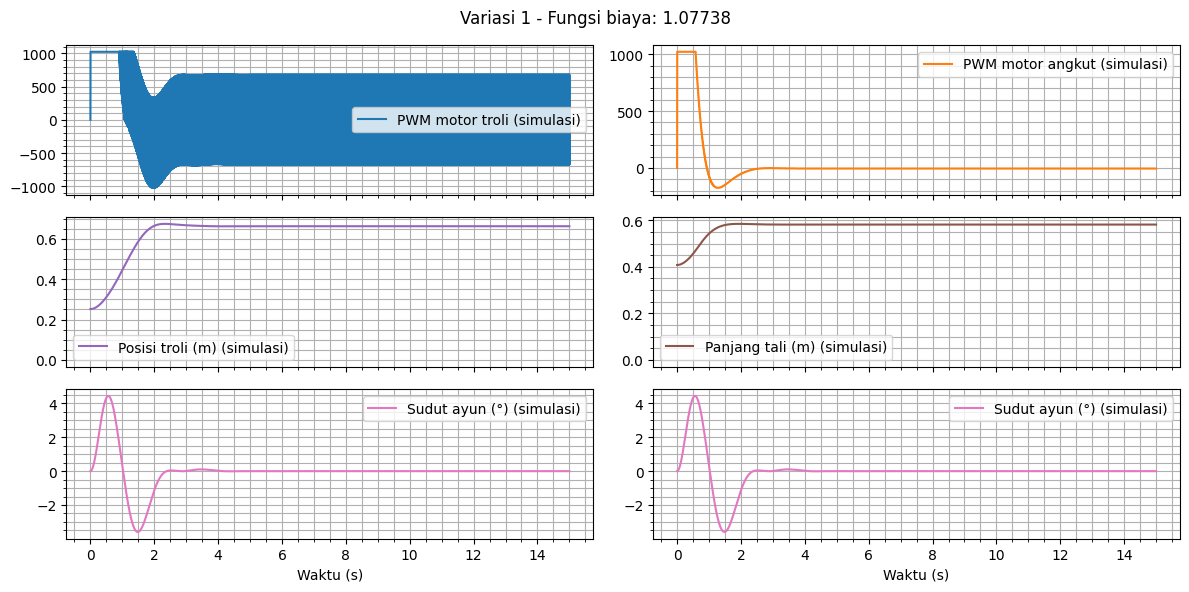

Initial condition:  {'x': 0.6874, 'l': 0.5781, 'theta': 0.0}
Setpoint:  {'x': 0.2105, 'l': 0.4397}
Variasi 2 - Fungsi biaya: 1.18278


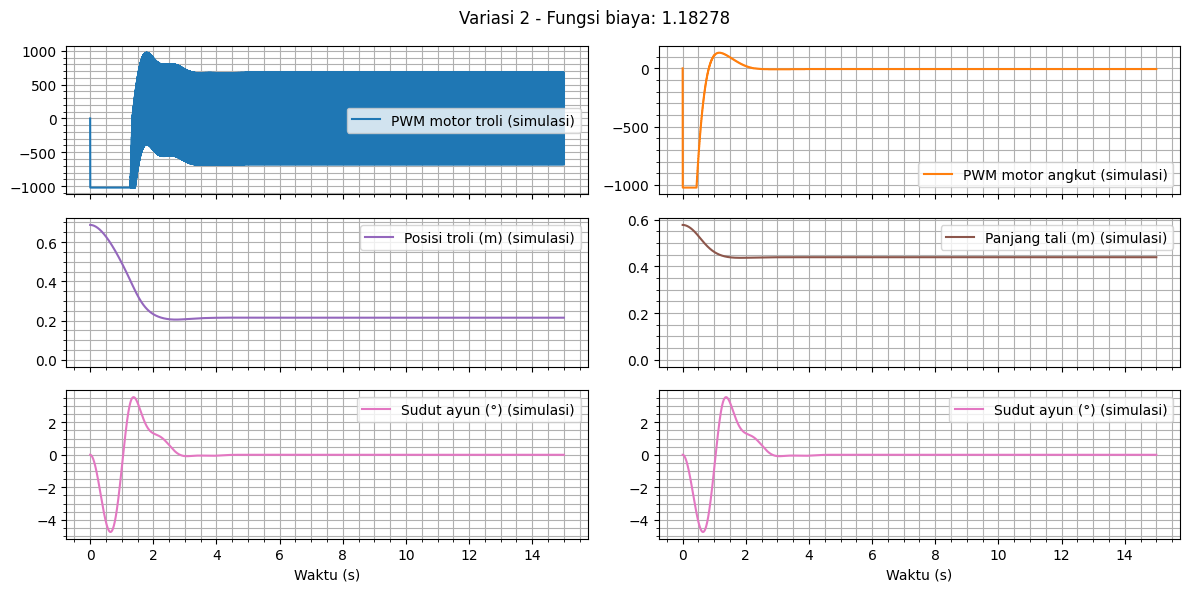

Initial condition:  {'x': 0.9335, 'l': 0.4954, 'theta': 0.0}
Setpoint:  {'x': 0.261, 'l': 0.5535}
Variasi 3 - Fungsi biaya: 1.41398


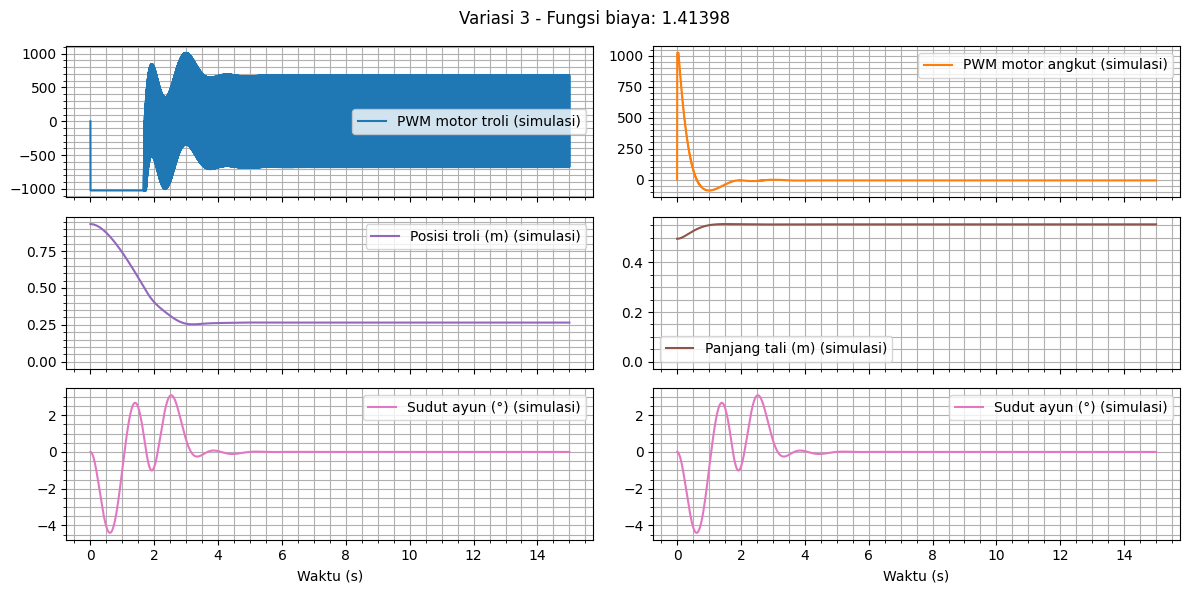

Initial condition:  {'x': 0.4587, 'l': 0.4064, 'theta': 0.0}
Setpoint:  {'x': 1.1531, 'l': 0.507}
Variasi 4 - Fungsi biaya: 1.42016


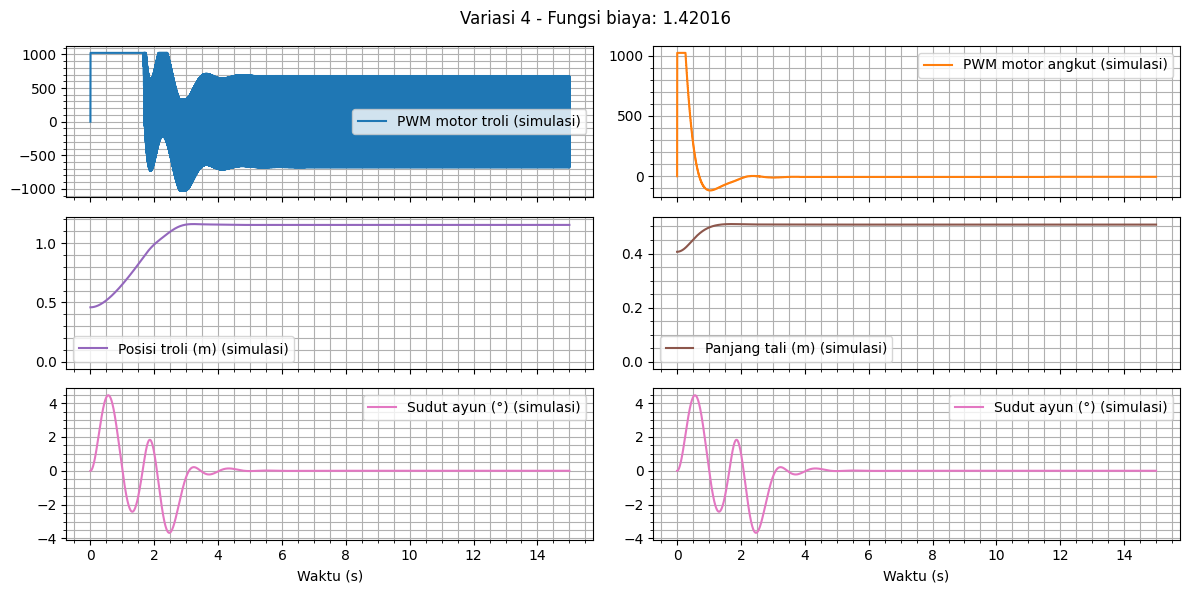

Initial condition:  {'x': 1.2418, 'l': 0.4539, 'theta': 0.0}
Setpoint:  {'x': 0.1026, 'l': 0.5178}
Variasi 5 - Fungsi biaya: 1.91425


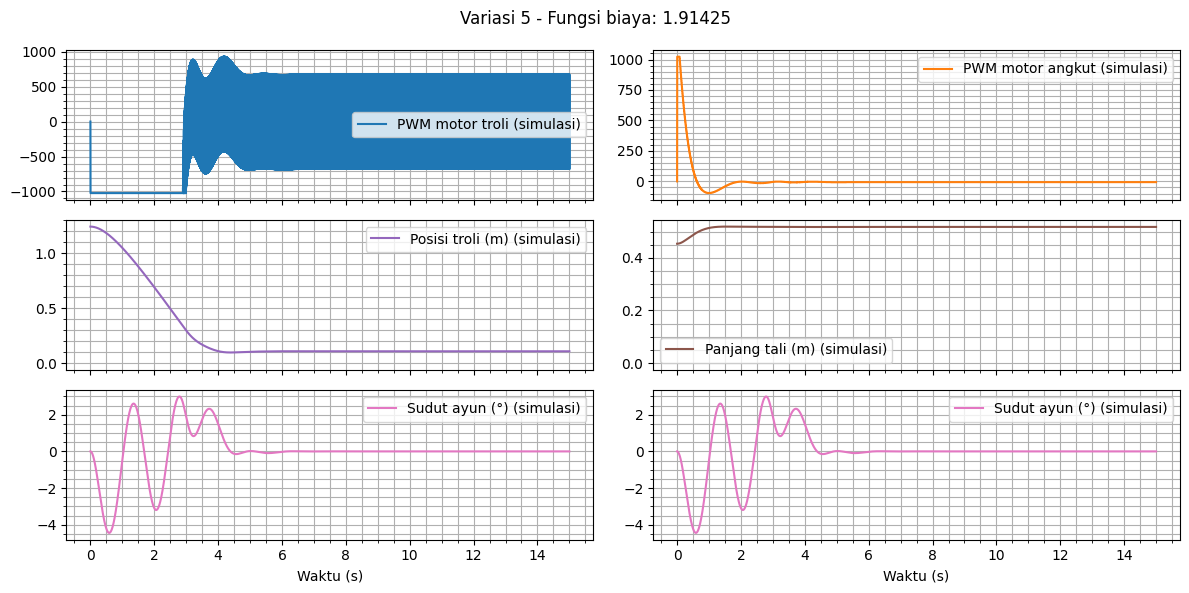

Initial condition:  {'x': 0.7257, 'l': 0.4327, 'theta': 0.0}
Setpoint:  {'x': 0.1669, 'l': 0.498}
Variasi 6 - Fungsi biaya: 1.2801


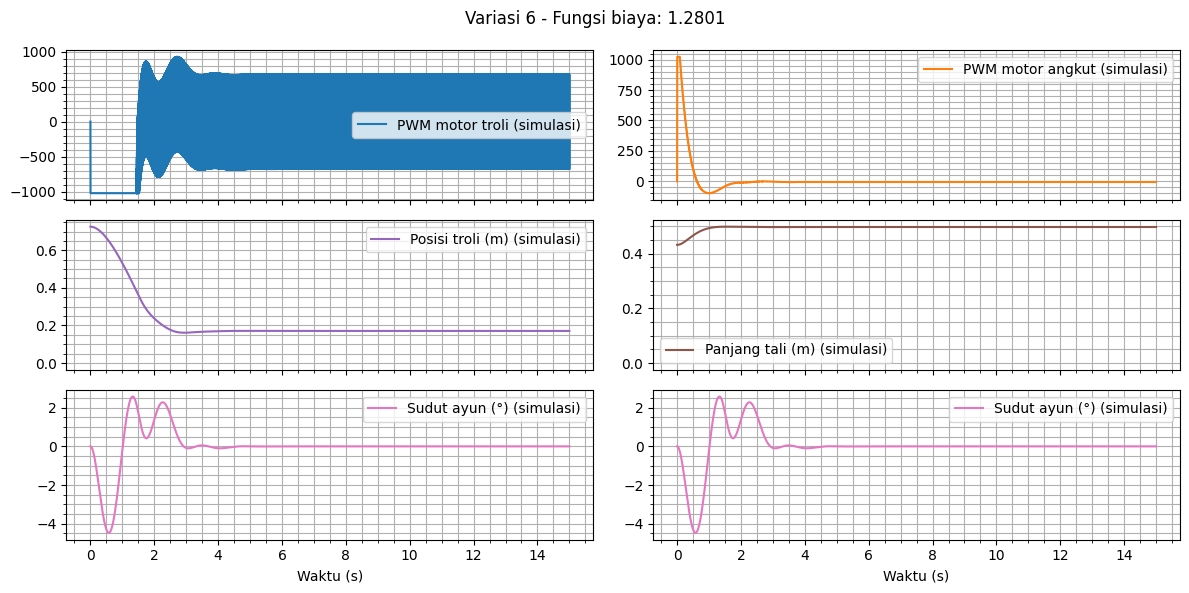

Initial condition:  {'x': 0.3219, 'l': 0.4218, 'theta': 0.0}
Setpoint:  {'x': 0.6137, 'l': 0.5875}
Variasi 7 - Fungsi biaya: 0.97995


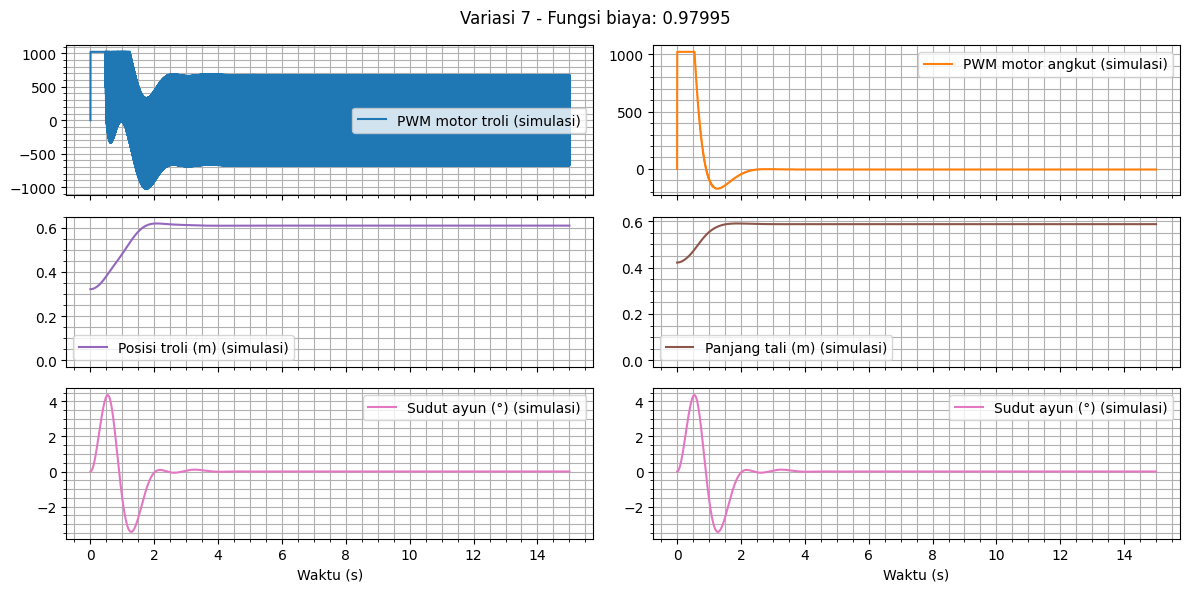

Initial condition:  {'x': 1.2233, 'l': 0.4174, 'theta': 0.0}
Setpoint:  {'x': 0.3331, 'l': 0.5943}
Variasi 8 - Fungsi biaya: 1.61612


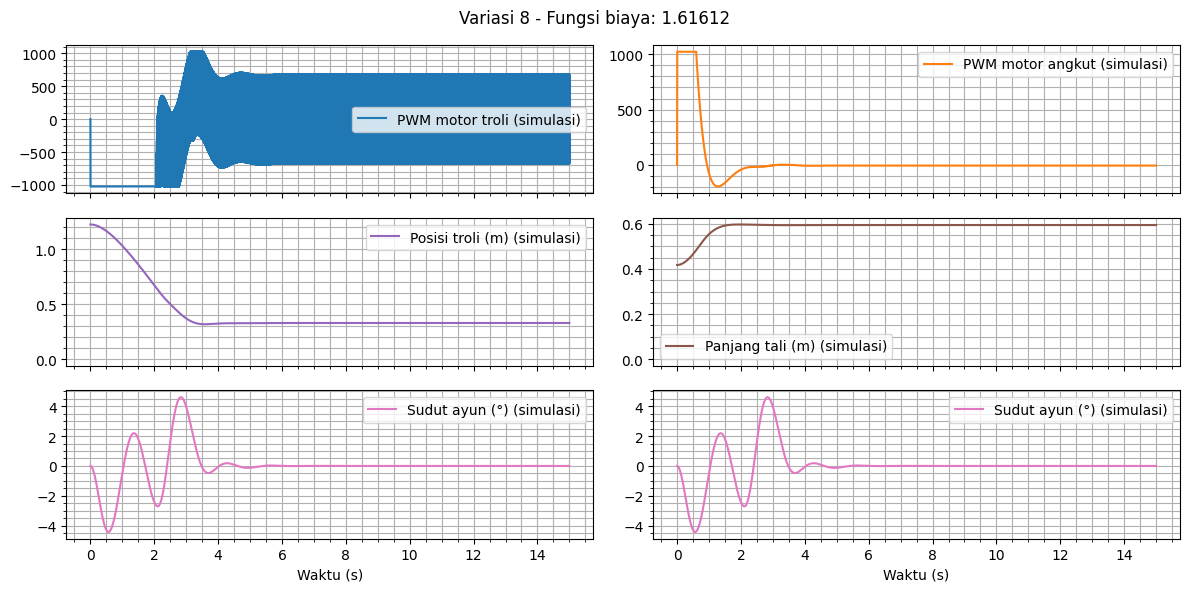

Initial condition:  {'x': 0.8584, 'l': 0.5288, 'theta': 0.0}
Setpoint:  {'x': 0.1827, 'l': 0.4483}
Variasi 9 - Fungsi biaya: 1.39247


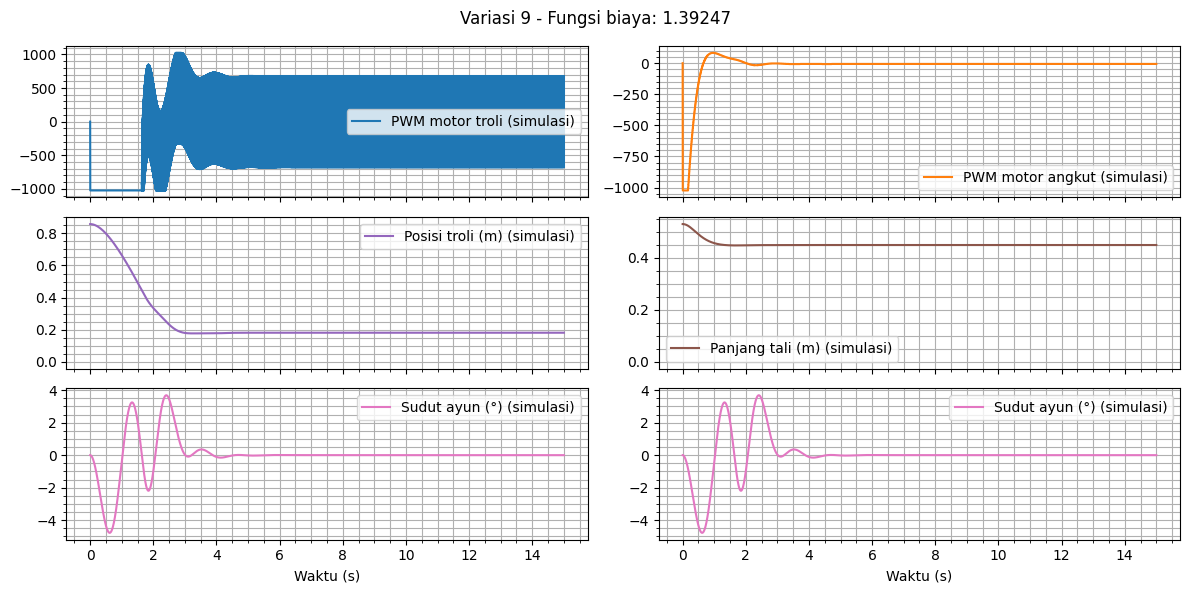

Initial condition:  {'x': 0.4882, 'l': 0.4967, 'theta': 0.0}
Setpoint:  {'x': 0.9791, 'l': 0.5934}
Variasi 10 - Fungsi biaya: 1.14954


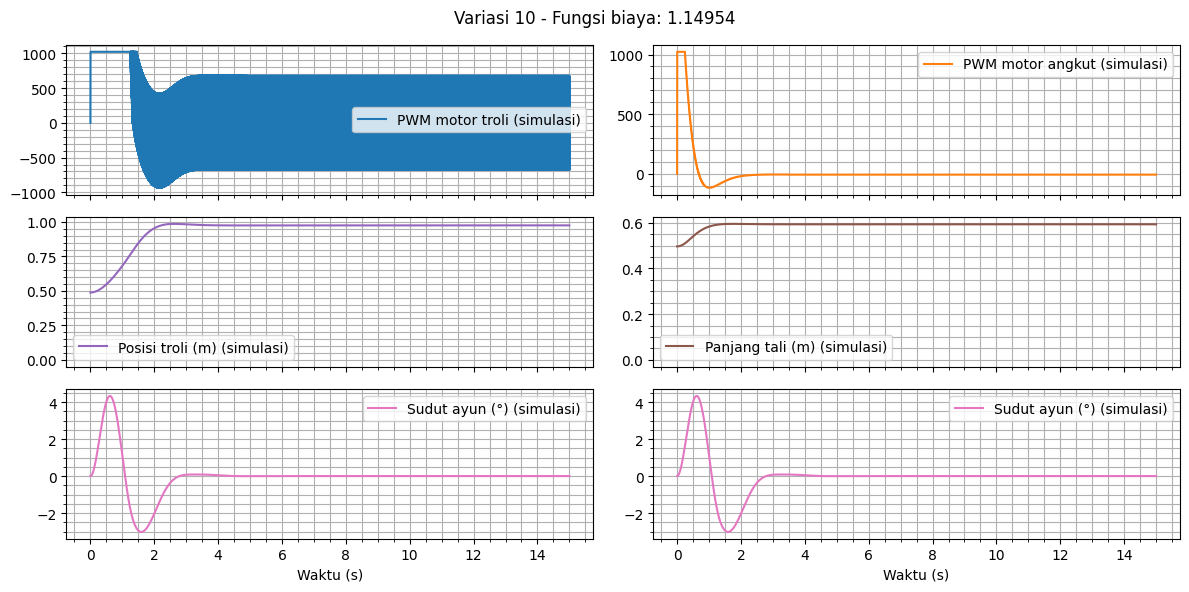

Minimum cost:  0.979953274766778
Maximum cost:  1.914246093746157
Total cost: 13.426741083649889


In [19]:
# Load the best parameters
SMC_best_parameters = ut.load_json(RESULTS_PATH + "SMC_best_parameters.json")

for parameter in SMC_best_parameters:
    print(parameter, SMC_best_parameters[parameter]["value"], end=", ")
print()

random_variations = [variations_json[index] for index in variation_names]
# Simulate the gantry crane system using the best parameters
total_cost = 0
costs = []
for index, variation in enumerate(random_variations):
    initial_conditions = {
            "x": variation["initial_condition"][0],
            "l": variation["initial_condition"][1],
            "theta": variation["initial_condition"][2],
        }

    setpoints = {
        "x": variation["setpoint"][0],
        "l": variation["setpoint"][1],
    }

    print("Initial condition: ", initial_conditions)
    print("Setpoint: ", setpoints)
    simulator.simulate_with_SMC(
        GANTRY_CRANE_PARAMETERS,
        SMC_best_parameters,
        setpoints=setpoints,
        initial_conditions=initial_conditions,
    )
    simulation_result = simulator.get_results()

    cost = cost_function(SMC_best_parameters, [variation])
    total_cost += cost
    costs.append(cost)

    print(f"Variasi {index+1} - Fungsi biaya: {round(cost, 5)}")

    # Create a figure and a set of subplots
    figure, ax = plt.subplots(3, 2, figsize=(12, 6), sharex=True)
    plt.rcParams.update({"font.size": 10})
    figure.suptitle(f"Variasi {index+1} - Fungsi biaya: {round(cost, 5)}", fontsize=12)
    ut.add_to_subplot(ax[0, 0], simulation_result["time"], simulation_result["trolley_motor_pwm"], ylabel="PWM motor troli (simulasi)", color=plt.get_cmap("tab20")(0))
    ut.add_to_subplot(ax[0, 1], simulation_result["time"], simulation_result["hoist_motor_pwm"], ylabel="PWM motor angkut (simulasi)", color=plt.get_cmap("tab20")(2))
    # ut.add_to_subplot(ax[1, 0], simulation_result["time"], simulation_result["trolley_motor_voltage"], ylabel="Tegangan motor troli (V) (simulasi)", color=plt.get_cmap("tab20")(4))
    # ut.add_to_subplot(ax[1, 1], simulation_result["time"], simulation_result["hoist_motor_voltage"], ylabel="Tegangan motor angkut (V) (simulasi)", color=plt.get_cmap("tab20")(6))
    ut.add_to_subplot(ax[1, 0], simulation_result["time"], simulation_result["trolley_position"], ylabel="Posisi troli (m) (simulasi)", color=plt.get_cmap("tab20")(8))
    # ut.add_to_subplot(ax[1, 0], simulation_result["time"], simulation_result["trolley_speed"], ylabel="Kecepatan troli (m/s) (simulasi)", color=plt.get_cmap("tab20")(8), linestyle="--")
    ut.add_to_subplot(ax[1, 1], simulation_result["time"], simulation_result["cable_length"], ylabel="Panjang tali (m) (simulasi)", color=plt.get_cmap("tab20")(10))
    # ut.add_to_subplot(ax[1, 1], simulation_result["time"], simulation_result["cable_speed"], ylabel="Kecepatan tali (m/s) (simulasi)", color=plt.get_cmap("tab20")(10), linestyle="--")
    ut.add_to_subplot(ax[2, 0], simulation_result["time"], np.rad2deg(simulation_result["sway_angle"]), "Waktu (s)", "Sudut ayun (°) (simulasi)", color=plt.get_cmap("tab20")(12))
    ut.add_to_subplot(ax[2, 1], simulation_result["time"], np.rad2deg(simulation_result["sway_angle"]), "Waktu (s)", "Sudut ayun (°) (simulasi)", color=plt.get_cmap("tab20")(12))

    # ut.add_to_subplot(ax[0, 0], dataset["time"], dataset["trolley_motor_pwm"], ylabel="PWM motor troli (data)", color=plt.get_cmap("tab20")(1))
    # ut.add_to_subplot(ax[0, 1], dataset["time"], dataset["hoist_motor_pwm"], ylabel="PWM motor angkut (data)", color=plt.get_cmap("tab20")(3))
    # ut.add_to_subplot(ax[1, 0], dataset["time"], dataset["trolley_motor_voltage"], ylabel="Tegangan motor troli (V) (data)", color=plt.get_cmap("tab20")(5))
    # ut.add_to_subplot(ax[1, 1], dataset["time"], dataset["hoist_motor_voltage"], ylabel="Tegangan motor angkut (V) (data)", color=plt.get_cmap("tab20")(7))
    # ut.add_to_subplot(ax[2, 0], dataset["time"], dataset["trolley_position"], ylabel="Posisi troli (m) (data)", color=plt.get_cmap("tab20")(9))
    # ut.add_to_subplot(ax[2, 0], dataset["time"], dataset["trolley_speed"], ylabel="Kecepatan troli (m/s) (data)", color=plt.get_cmap("tab20")(9), linestyle="--")
    # ut.add_to_subplot(ax[2, 1], dataset["time"], dataset["cable_length"], ylabel="Panjang tali (m) (data)", color=plt.get_cmap("tab20")(11))
    # ut.add_to_subplot(ax[2, 1], dataset["time"], dataset["cable_speed"], ylabel="Kecepatan tali (m/s) (data)", color=plt.get_cmap("tab20")(11), linestyle="--")
    # ut.add_to_subplot(ax[3, 0], dataset["time"], dataset["sway_angle"], "Waktu (s)", "Sudut ayun (°) (data)", color=plt.get_cmap("tab20")(13))
    # ut.add_to_subplot(ax[3, 1], dataset["time"], dataset["sway_angle"], "Waktu (s)", "Sudut ayun (°) (data)", color=plt.get_cmap("tab20")(13))
    # ax[3, 0].set_ylim(-max_sway_angle, max_sway_angle)
    # ax[3, 1].set_ylim(-max_sway_angle, max_sway_angle)
    plt.tight_layout()

    # Save the figure as SVG
    plt.savefig(RESULTS_PATH + f"figure/variation_{index+1}.svg")
    plt.show()

print("Minimum cost: ", np.min(costs))
print("Maximum cost: ", np.max(costs))
print(f"Total cost: {total_cost}")